# Обнаружение SMS-спама

В этом ноутбуке решается задача классификации SMS-сообщений на спам и не спам.
Используем [датасет](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset), состоящий из сообщений на английском языке, размеченных вручную.

В качестве модели выбран наивный байесовский классификатор $-$ простой, быстрый и эффективный метод для текстовых данных. Проведём его тестирование на задаче обнаружения SMS-спама.

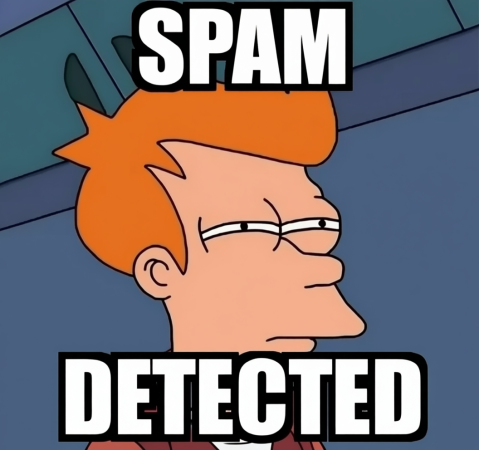

# Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix

# Вспомогательные настройки
plt.style.use('ggplot')
pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 42

# Загрузка данных

Данные содержат по одному сообщению в каждой строке. Каждая строка состоит из двух столбцов: `v1` содержит метку, а `v2` $-$ исходный текст:

In [ ]:
data = pd.read_csv('spam.csv', encoding='latin1')

In [ ]:
data[:3]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,NaN,NaN,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


Строки со смещённой структурой:

In [ ]:
data[data['Unnamed: 3'].notna()]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,"Your free ringtone is waiting to be collected. Simply text the password \MIX\"" to 85069 to verify. Get Usher and Britney. FML",PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... But if the person is so special,why to miss them,"just Keep-in-touch\"" gdeve.."""
899,spam,"Your free ringtone is waiting to be collected. Simply text the password \MIX\"" to 85069 to verify. Get Usher and Britney. FML",PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
1038,ham,"Edison has rightly said, \A fool can ask more questions than a wise man can answer\"" Now you know why all of us are speechless during ViVa.. GM",GN,GE,"GNT:-)"""
2170,ham,\CAN I PLEASE COME UP NOW IMIN TOWN.DONTMATTER IF URGOIN OUTL8R,JUST REALLYNEED 2DOCD.PLEASE DONTPLEASE DONTIGNORE MYCALLS,"U NO THECD ISV.IMPORTANT TOME 4 2MORO\""""",NaN
2255,ham,I just lov this line: \Hurt me with the truth,I don't mind,i wil tolerat.bcs ur my someone..... But,"Never comfort me with a lie\"" gud ni8 and sweet dreams"""
3145,ham,\SHIT BABE.. THASA BIT MESSED UP.YEH,SHE SHUDVETOLD U. DID URGRAN KNOW?NEWAY,"ILLSPEAK 2 U2MORO WEN IM NOT ASLEEP...\""""",NaN
3506,ham,Two fundamentals of cool life: \Walk,"like you are the KING\""...! OR \""Walk like you Dont care","whoever is the KING\""!... Gud nyt""",NaN
3525,ham,\HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DEAD 2 DA WRLD. BEEN SLEEPING ON DA SOFA ALL DAY,HAD A COOL NYTHO,TX 4 FONIN HON,"CALL 2MWEN IM BK FRMCLOUD 9! J X\"""""
4668,ham,"When I was born, GOD said, \Oh No! Another IDIOT\"". When you were born",GOD said,"\""OH No! COMPETITION\"". Who knew","one day these two will become FREINDS FOREVER!"""


# Целевая переменная

In [ ]:
y = data['v1'].copy().rename('spam')
y = y.map({'ham': 0, 'spam': 1})

In [ ]:
pd.concat([
    y.value_counts(),
    y.value_counts(normalize=True).round(3)
], axis=1)

,count,proportion
spam,,
0,4825,0.866
1,747,0.134


# Текстовый признак

In [ ]:
X = data.drop(columns=['v1']).copy()

# Восстанавливаем текстовый признак
X = (
    X.fillna('')
    .apply(' '.join, axis=1)
    .str.strip()
    .rename('text')
)

In [ ]:
X[:3]

,text
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,Ok lar... Joking wif u oni...
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


In [ ]:
print(type(X))

<class 'pandas.core.series.Series'>


### Распределение длины текста

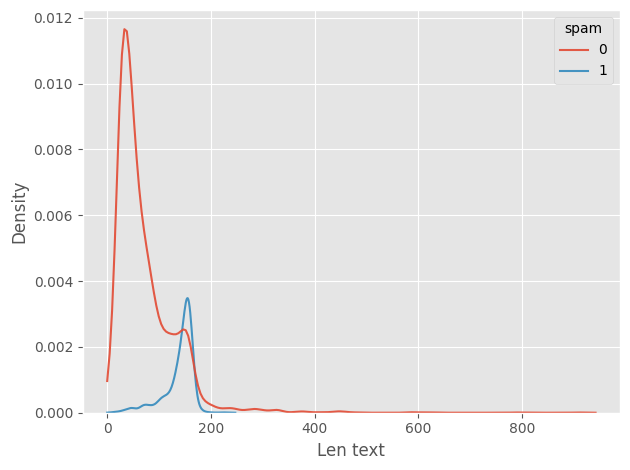

In [ ]:
sns.kdeplot(x=X.str.len(), hue=y, alpha=0.9, clip=(0, None))
plt.xlabel('Len text')
plt.tight_layout()
plt.show()

> `Не спам` $-$ в основном короткие или средние по длине сообщения (коротких сообщений больше).
>
> `Спам` не стремится к минимальной длине и имитирует среднюю длину обычных сообщений.

### Доля заглавных букв в каждом тексте

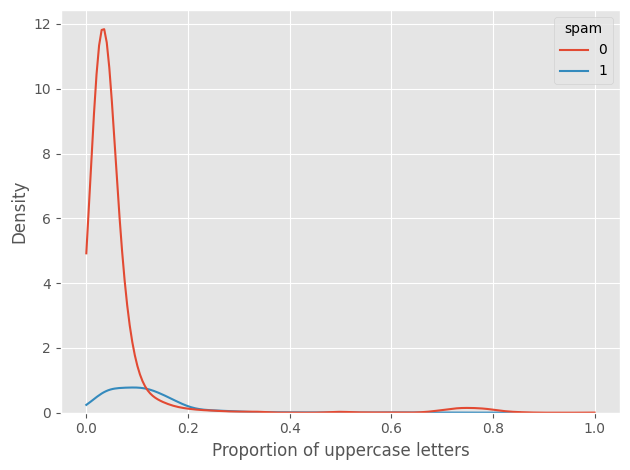

In [ ]:
x_isupper = X.apply(lambda x: sum(c.isupper() for c in x) / len(x) if len(x) > 0 else 0)
sns.kdeplot(x=x_isupper, hue=y, clip=(0, 1))
plt.xlabel('Proportion of uppercase letters')
plt.tight_layout()
plt.show()

> `Спам` иногда содержит больше заглавных букв.

In [ ]:
# Примеры НЕ спама с высокой долей заглавных букв:
mask = (x_isupper > 0.6) & (x_isupper < 0.9) & (y == 0)
X[mask]

,text
14,I HAVE A DATE ON SUNDAY WITH WILL!!
43,WHO ARE YOU SEEING?
72,HI BABE IM AT HOME NOW WANNA DO SOMETHING? XX
128,HEY GIRL. HOW R U? HOPE U R WELL ME AN DEL R BAK! AGAIN LONG TIME NO C! GIVE ME A CALL SUM TIME FROM LUCYxx
241,PLEASSSSSSSEEEEEE TEL ME V AVENT DONE SPORTSx
...,...
5202,WOT STUDENT DISCOUNT CAN U GET ON BOOKS?
5224,"\OH FUCK. JUSWOKE UP IN A BED ON A BOATIN THE DOCKS. SLEPT WID 25 YEAR OLD. SPINOUT! GIV U DA GOSSIP L8R. XXX\"""""
5266,HI DARLIN ITS KATE ARE U UP FOR DOIN SOMETHIN TONIGHT? IM GOING TO A PUB CALLED THE SWAN OR SOMETHING WITH MY PARENTS FOR ONE DRINK SO PHONE ME IF U CAN
5388,NOT MUCH NO FIGHTS. IT WAS A GOOD NITE!!


### Доля цифр в каждом тексте

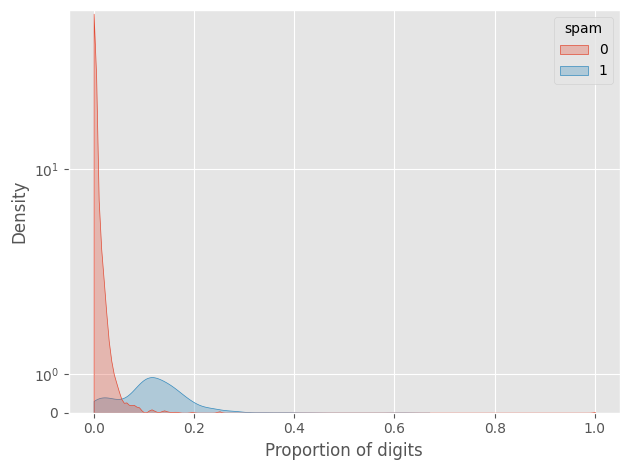

In [ ]:
x_isdigit = X.apply(lambda x: sum(c.isdigit() for c in x) / len(x) if len(x) > 0 else 0)
sns.kdeplot(x=x_isdigit, hue=y, alpha=0.3, fill=True, clip=(0, 1))
plt.yscale('symlog', linthresh=5)  # симметричный логарифмический масштаб
plt.xlabel('Proportion of digits')
plt.tight_layout()
plt.show()

> `Спам` содержит больше цифр.

### Доля специальных символов в каждом тексте

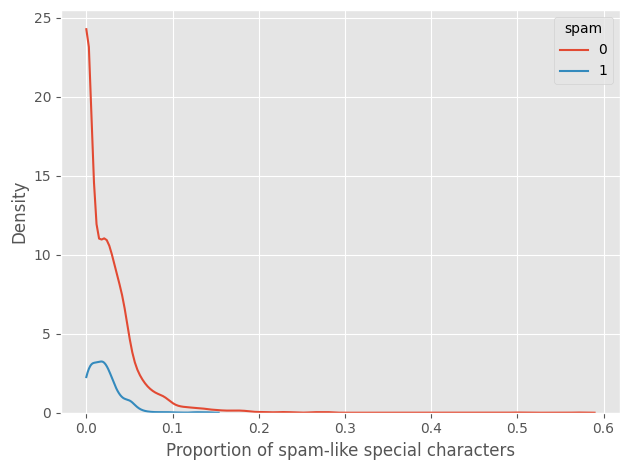

In [ ]:
x_special = X.apply(
    lambda x: sum(1 for c in x if c in '@#$%^&*_+-=[]{}|\\;:\'"<>?/~`!') / len(x)
    if len(x) > 0 else 0
)

sns.kdeplot(x=x_special, hue=y, clip=(0, 1))
plt.xlabel('Proportion of spam-like special characters')
plt.tight_layout()
plt.show()

> `Спам` маскируется под обычный текст.

### Строки с не-ASCII символами

In [ ]:
# % сообщений с не-ASCII в спаме и не спаме
df_temp = pd.DataFrame({
    'has_non_ascii': X.apply(lambda s: any(ord(c) > 127 for c in s)),
    'spam': y
})

df_temp.groupby('spam')['has_non_ascii'].mean()

,has_non_ascii
spam,
0,0.046632
1,0.345382


In [ ]:
# Примеры, содержащие не-ASCII символы
X[df_temp.has_non_ascii]

,text
5,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv"
8,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
12,"URGENT! You have won a 1 week FREE membership in our å£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18"
18,Fine if thatåÕs the way u feel. ThatåÕs the way its gota b
19,"England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 87077 Try:WALES, SCOTLAND 4txt/Ì¼1.20 POBOXox36504W45WQ 16+"
...,...
5511,"ItÛ÷s reassuring, in this crazy world."
5524,You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p på£3.99
5540,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O å£250 3 WANT å£800
5567,"This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate."


In [ ]:
# Пытаемся исправить искажённые символы, вызванные конфликтом кодировок
X = X.apply(
    lambda s: s.encode('latin1').decode('utf-8', errors='ignore')
)

In [ ]:
# Примеры, ранее содержащие не-ASCII символы
X[df_temp.has_non_ascii]

,text
5,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, 1.50 to rcv"
8,WINNER!! As a valued network customer you have been selected to receivea 900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
12,"URGENT! You have won a 1 week FREE membership in our 100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18"
18,Fine if thats the way u feel. Thats the way its gota b
19,"England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 87077 Try:WALES, SCOTLAND 4txt/̼1.20 POBOXox36504W45WQ 16+"
...,...
5511,"Its reassuring, in this crazy world."
5524,You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p p3.99
5540,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O 250 3 WANT 800
5567,"This is the 2nd time we have tried 2 contact u. U have won the 750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate."


In [ ]:
# Оставшиеся строки с не-ASCII символами
X[X.apply(lambda s: any(ord(c) > 127 for c in s))]

,text
19,"England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 87077 Try:WALES, SCOTLAND 4txt/̼1.20 POBOXox36504W45WQ 16+"
988,"Yun ah.the ubi one say if _ wan call by tomorrow.call 67441233 look for irene.ere only got bus8,22,65,61,66,382. Ubi cres,ubi tech park.6ph for 1st 5wkg days.̬n"
2790,U۪ve Bin Awarded 50 to Play 4 Instant Cash. Call 08715203028 To Claim. EVERY 9th Player Wins Min 50-500. OptOut 08718727870
2901,"Bill, as in: Are there any letters for me. i۪m expecting one from orange that isn۪t a bill but may still say orange on it."
4760,It's ̩ only $140 ard... rest all ard $180 at least...Which is ̩ price 4 ̩ 2 bedrm ($900)
5400,HARD BUT TRUE: How much you show &amp; express your love to someone....that much it will hurt when they leave you or you get seperated...!_??۬ud evening...


# Наивный байесовский классификатор

Разделим данные на обучающую и тестовую выборки с сохранением баланса классов.

Преобразуем тексты в числовые признаки с помощью `CountVectorizer`.  

Обучим классификатор `MultinomialNB` с небольшим сглаживанием и получим предсказания на тестовой выборке.

In [ ]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    shuffle=True,
    random_state=RANDOM_STATE,
)

# Векторизация текста
cv = CountVectorizer(
    token_pattern=r"(?u)\b[\w']+\b|\d+|[@#$%^&*()_+=\[\]{}|\\;:\'\",<>?/~`!-]+",
    lowercase=True,
    stop_words='english',
    max_features=25_000,
    ngram_range=(1, 2),
    min_df=1,
    max_df=0.5
)

X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)

# Наивный Байес: обучение и предсказание
nb = MultinomialNB(alpha=0.25)
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

**Метрики:**

In [ ]:
pd.DataFrame(
    classification_report(y_test, y_pred, output_dict=True, target_names=['ham', 'spam'])
).T.round(3)

,precision,recall,f1-score,support
ham,0.994,0.996,0.995,966.000
spam,0.973,0.960,0.966,149.000
accuracy,0.991,0.991,0.991,0.991
macro avg,0.983,0.978,0.981,1115.000
weighted avg,0.991,0.991,0.991,1115.000


**Матрица ошибок:**

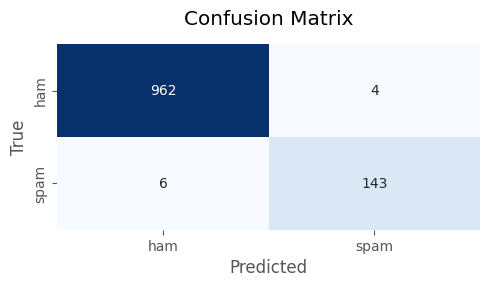

In [ ]:
plt.figure(figsize=(5, 3))
sns.heatmap(
    confusion_matrix(y_test, y_pred, labels=[0, 1]),
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=['ham', 'spam'],
    yticklabels=['ham', 'spam']
)

plt.title('Confusion Matrix', y=1.06)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()